In [1]:
#%% Import libraries
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import ast
from scipy.ndimage import gaussian_filter
import pickle
import scipy.stats

In [2]:
#%%
errors = np.zeros((768))
its = np.zeros((768))
mts = np.zeros((768))

In [3]:
#%%
def euclidean_dist(df):
    errors = list()
    for i in range(len(df)):
        errors.append(np.sqrt((df['target_x'][i] - df['transfer_mouse.x'][i][-1])**2 + (df['target_y'][i] - df['transfer_mouse.y'][i][-1])**2))        

    return errors       
def angular_dist(vec1, vec2):
    uv1 = vec1/np.linalg.norm(vec1)
    uv2 = vec2/np.linalg.norm(vec2)
    dot_prod = np.dot(uv1, uv2)
    return np.arccos(dot_prod)

def rotate(x, y, angle):
    radians = (np.pi/180)*angle
    cos_val = np.cos(radians)
    sin_val = np.sin(radians)
    nx = x*cos_val + y*sin_val
    ny = y*cos_val - x*sin_val
    return [nx, ny];


In [33]:
data = pd.read_csv('data//old//2000.csv')

In [34]:
def data_cleanup(data):
    #Preliminary cleanup. Includes dropping NAs, separating in three sets and resetting indices to start from 0
    data_baseline = data.dropna(subset = ['baseline_mouse.x'], inplace = False)
    data_baseline.dropna('columns', inplace = True)
    data_baseline.reset_index(drop = True, inplace = True)
    data_rotated = data.dropna(subset = ['rotated_mouse.x'], inplace = False)
    data_rotated.dropna('columns', inplace = True)
    data_rotated.reset_index(drop = True, inplace = True)
    data_transfer = data.dropna(subset = ['transfer_mouse.x'], inplace = False)
    data_transfer.dropna('columns', inplace = True)
    data_transfer.reset_index(drop = True, inplace = True)
    
    #Convert string lists to regular lists
    for column in data_rotated.columns:
        try:
            data_rotated[column] = data_rotated[column].apply(ast.literal_eval)
            data_baseline[column] = data_baseline[column].apply(ast.literal_eval)
            data_transfer[column] = data_transfer[column].apply(ast.literal_eval)            
        except:
            print(column)
    return data_baseline, data_rotated, data_transfer

In [35]:
data_baseline, data_rotated, data_transfer = data_cleanup(data)

<ipython-input-34-de0e4bdf1c57>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_baseline.dropna('columns', inplace = True)
<ipython-input-34-de0e4bdf1c57>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_rotated.dropna('columns', inplace = True)
<ipython-input-34-de0e4bdf1c57>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_transfer.dropna('columns', inplace = True)
<ipython-input-34-de0e4bdf1c57>:16: SettingWithCopyW

target_x
target_y
rotation
blocks.thisRepN
blocks.thisTrialN
blocks.thisN
blocks.thisIndex
block_trials.thisRepN
block_trials.thisTrialN
block_trials.thisN
block_trials.thisIndex
rotated_target.started
rotated_target.stopped
rotated_fixation.started
rotated_fixation.stopped
rotated_mouse.x
rotated_mouse.y
rotated_mouse.leftButton
rotated_mouse.midButton
rotated_mouse.rightButton
rotated_mouse.time
rotated_mouse.started
rotated_mouse.stopped
rotated_target_feedback.started
rotated_target_feedback.stopped
rotated_fixation_feedback.started
rotated_fixation_feedback.stopped
participant
session
date
expName
psychopyVersion
frameRate


In [36]:
baseline_fix_pos = np.zeros((64, 2))
for trial in range(64):
    try:
        baseline_fix_pos[trial][:] = np.array(rotate(data_baseline['baseline_mouse.x'][trial][-1], data_baseline['baseline_mouse.y'][trial][-1], 0))        
    except:
        print('here')

rotated_fix_pos = np.zeros((640, 2))
for trial in range(640):
    try:
        rotated_fix_pos[trial][:] = np.array(rotate(data_rotated['rotated_mouse.x'][trial][-1], data_rotated['rotated_mouse.y'][trial][-1], 90))        
    except:
        print('here')
        
transfer_fix_pos = np.zeros((64, 2))
for trial in range(64):
    try:
        transfer_fix_pos[trial][:] = np.array(rotate(data_rotated['rotated_mouse.x'][trial][-1], data_rotated['rotated_mouse.y'][trial][-1], 0))        
    except:
        print('here')


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


In [37]:
errors = np.zeros(768)
ang_errors = np.zeros(768)
for trial in range(64):
    errors[trial] = np.sqrt((baseline_fix_pos[trial][0] - data_baseline['target_x'][trial])**2 + (baseline_fix_pos[trial][1] - data_baseline['target_y'][trial])**2)
    ang_errors[trial] = angular_dist(baseline_fix_pos[trial], [data_baseline['target_x'][trial], data_baseline['target_y'][trial]])
for trial in range(640):
    errors[trial+64] = np.sqrt((rotated_fix_pos[trial][0] - data_rotated['target_x'][trial])**2 + (rotated_fix_pos[trial][1] - data_rotated['target_y'][trial])**2)
    ang_errors[trial+64] = angular_dist(rotated_fix_pos[trial], [data_rotated['target_x'][trial], data_rotated['target_y'][trial]])
for trial in range(64):
    errors[trial+704] = np.sqrt((transfer_fix_pos[trial][0] - data_transfer['target_x'][trial])**2 + (transfer_fix_pos[trial][1] - data_transfer['target_y'][trial])**2)
    ang_errors[trial+704] = angular_dist(transfer_fix_pos[trial], [data_transfer['target_x'][trial], data_transfer['target_y'][trial]])
    

<ipython-input-3-37506489b2d9>:9: RuntimeWarning: invalid value encountered in true_divide
  uv1 = vec1/np.linalg.norm(vec1)


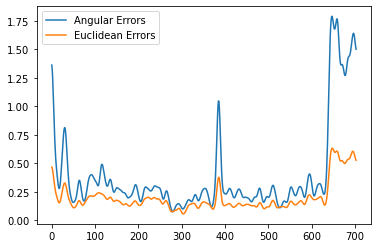

In [38]:
plt_angular, = plt.plot(gaussian_filter(ang_errors[64:], sigma = 4))
plt_euclidean, = plt.plot(gaussian_filter(errors[64:], sigma = 4))
plt.legend((plt_angular, plt_euclidean), ('Angular Errors', "Euclidean Errors"))